In [ ]:
# Imports
import sys
import os
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from preprocessing.advanced import clean_data
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [ ]:
data = clean_data("fraud.csv") 

Importing data...
splitting time columns...
Cyclically encoding features...
Dropping columns...
Rounding columns...
Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'street', 'city',
       'state', 'zip', 'city_pop', 'job', 'trans_num', 'is_fraud',
       'trans_minute', 'trans_hour', 'trans_day', 'trans_month', 'trans_year',
       'trans_dayofweek', 'dob_day', 'dob_month', 'dob_year',
       'trans_minute_sin', 'trans_minute_cos', 'trans_hour_sin',
       'trans_hour_cos', 'trans_day_sin', 'trans_day_cos', 'trans_month_sin',
       'trans_month_cos', 'trans_dayofweek_sin', 'trans_dayofweek_cos',
       'dob_day_sin', 'dob_day_cos', 'dob_month_sin', 'dob_month_cos'],
      dtype='object')
Encoding categorical features...
Rounding categorical columns...
             cc_num  merchant  category     amt  gender  street  city  state  \
0  2703186189652095       514         8    4.97       0     576   532     27   
1      630423337322       241         4  107.23       0     439   

In [ ]:
X = data.drop("is_fraud", axis=1)
y = data["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# SMOTE Sampling with Grid Search

## Define the pipeline

smote = SMOTE(
    random_state=42,
)

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) 

In [ ]:
# XGBoost
model_xgb = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda")
model_xgb.fit(X_train_smote, y_train_smote)

/home/cengelsen/.conda/envs/smote_test/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:12:46] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/cengelsen/.conda/envs/smote_test/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:12:46] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
## Classification report
y_pred = model_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Oranges")
plt.savefig("confusion_matrix_xgboost_advanced.png")
plt.close()

In [ ]:
## Shapley values
explainer = shap.TreeExplainer(model_xgb)
explanation = explainer(X_test)

shap_values = explanation.values
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

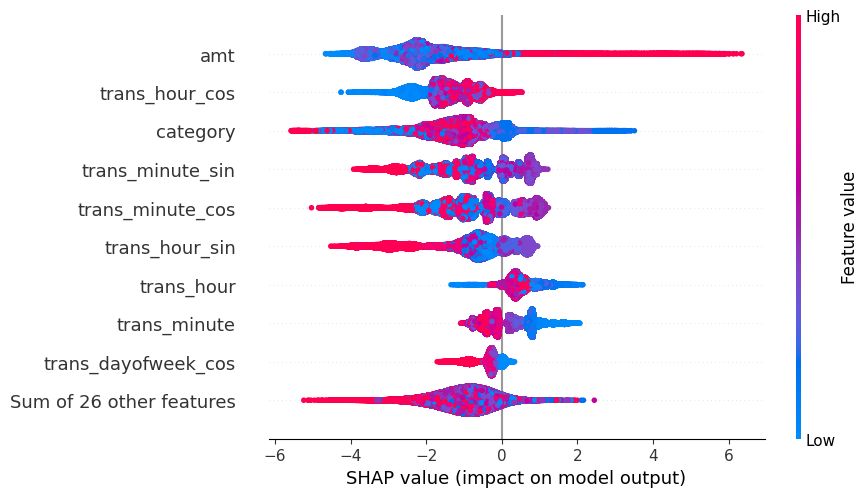

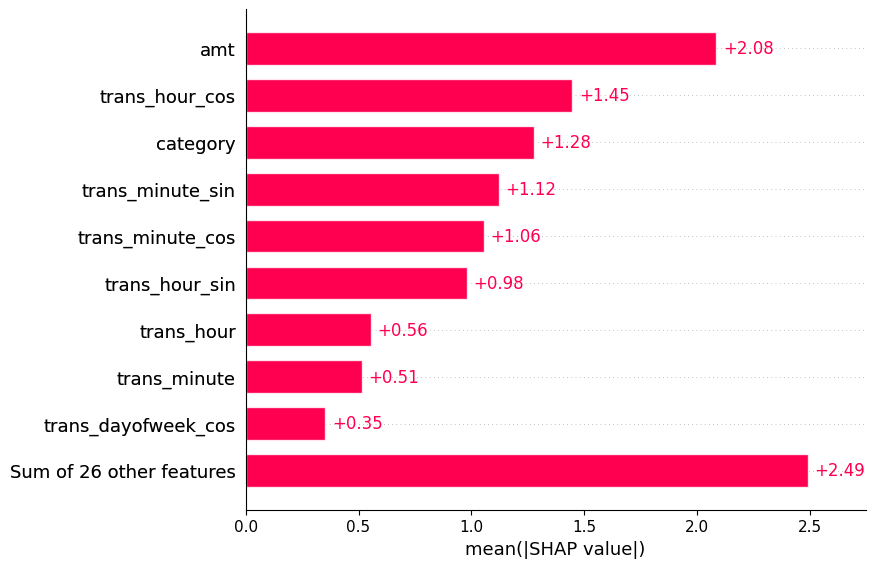

In [ ]:
explanation_plot = shap.Explanation(
    values=shap_values,
    base_values=explanation.base_values,
    data=X_test,
    feature_names=X.columns.tolist()
)

shap.plots.beeswarm(explanation_plot, max_display=10)
plt.savefig("shap_beeswarm_xgboost_advanced.png")
plt.close()

shap.plots.bar(explanation_plot, max_display=10)
plt.savefig("shap_bar_xgboost_advanced.png")
plt.close()

In [ ]:
from alibi.explainers import AnchorTabular
feature_names = X.columns.tolist()
predict_fn = lambda x: model_xgb.predict_proba(x)

explainer = AnchorTabular(predict_fn, feature_names)

explainer.fit(X_train_smote, disc_perc=(5, 10, 15, 25, 50, 75, 90))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (5, 10, 15, 25, 50, 75, 90)},
  'version': '0.9.6'}
)

In [ ]:
# Finds global rules

anchors = []
for i in tqdm(range(len(X_test[:5]))):  # or len(X_test)
    instance = X_test[i]
    explanation = explainer.explain(
        instance, 
        threshold=0.95, 
        verbose=False,
        batch_size=1024,
        )
    anchors.append(tuple(explanation.anchor))  # store as tuple for counting

anchor_counts = Counter(anchors)
print("Most common anchor rules for XGBoost:")
for rule, count in anchor_counts.most_common(10):
    print(f"{rule}: {count} times") 

100%|██████████| 5/5 [07:47<00:00, 93.59s/it] 


NameError: name 'Counter' is not defined

In [ ]:
# Neural Network
nn = tf.keras.models.Sequential([
    tf.keras.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

nn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

history = nn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)

In [ ]:
## Classification report
y_pred_prob = nn.predict(X_test).flatten()
threshold = 0.2  # Try different values
y_pred = (y_pred_prob >= threshold).astype(int)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"]).plot(cmap="Blues")
disp.plot()
plt.savefig("confusion_matrix_nn.png")
plt.close()

In [ ]:
print(type(X_test))

background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]

print(f"Using {len(background)} samples for SHAP analysis")

# Initialize SHAP explainer with TensorFlow model
print("Initializing SHAP DeepExplainer...")
explainer = shap.DeepExplainer(nn, background)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test)


print(f"SHAP values type: {type(shap_values)}")
print(f"Length of SHAP list: {len(shap_values)}")
print(f"Shape of first element: {np.array(shap_values[0]).shape}")
print(f"Shape of second element: {np.array(shap_values[1]).shape}")

In [ ]:
# Check the actual structure of the returned SHAP values
if isinstance(shap_values, list):
    # If DeepExplainer returned a list of arrays (one per class)
    shap_values_class_0 = shap_values[0]
    shap_values_class_1 = shap_values[1]
else:
    # If DeepExplainer returned a single array
    # For binary classification with a sigmoid output, the SHAP values
    # represent the positive class (fraud)
    shap_values_class_1 = shap_values
    # For the negative class, we can take the negative of the SHAP values
    shap_values_class_0 = -shap_values

In [ ]:
# Ensure proper shape: should match X_test's shape
if shap_values_class_0.shape != X_test.shape:
    shap_values_class_0 = np.squeeze(shap_values_class_0)
if shap_values_class_1.shape != X_test.shape:
    shap_values_class_1 = np.squeeze(shap_values_class_1)

feature_names = X.columns.tolist()

In [ ]:
# Generate summary plots
print("\nGenerating summary plot for non-fraud (class 0)...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_class_0, X_test, feature_names=feature_names, 
                 max_display=10, show=False, plot_type="bar")
plt.tight_layout()
plt.savefig("shap_summary_nonfraud.png")
plt.close()

print("\nGenerating summary plot for fraud (class 1)...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_class_1, X_test, feature_names=feature_names, 
                 max_display=10, show=False, plot_type="bar")
plt.tight_layout()
plt.savefig("shap_summary_fraud.png")
plt.close()


In [ ]:
print("\nGenerating beeswarm plot for non-fraud (class 0)...")
plt.figure(figsize=(12, 10))
explanation_nonfraud = shap.Explanation(
    values=shap_values_class_0,
    base_values=np.repeat(explainer.expected_value[0] if isinstance(explainer.expected_value, list) 
                          else explainer.expected_value, X_test.shape[0]),
    data=X_test,
    feature_names=feature_names
)
shap.plots.beeswarm(explanation_nonfraud, max_display=10, show=False)
plt.tight_layout()
plt.savefig("shap_beeswarm_nonfraud.png")
plt.close()

In [ ]:
print("\nGenerating beeswarm plot for fraud (class 1)...")
plt.figure(figsize=(12, 10))
explanation_fraud = shap.Explanation(
    values=shap_values_class_1,
    base_values=np.repeat(explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
                         else explainer.expected_value, X_test.shape[0]),
    data=X_test,
    feature_names=feature_names
)
shap.plots.beeswarm(explanation_fraud, max_display=10, show=False)
plt.tight_layout()
plt.savefig("shap_beeswarm_fraud.png")
plt.close()


In [ ]:
print("All SHAP plots saved to disk.")

In [ ]:
def predict_fn(x):
    # Returns predicted class labels
    return (nn.predict(x, verbose=0) >= 0.5).astype(int).flatten()


print(feature_names)

In [ ]:
explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_train)

X_test_sample = shuffle(X_test, random_state=42)

anchors = []
for i in tqdm(range(len(X_test_sample[:5]))):  # or len(X_test)
    instance = X_test_sample[i]
    explanation = explainer.explain(
        instance, 
        threshold=0.95, 
        verbose=False,
        batch_size=1024,
        )
    anchors.append(tuple(explanation.anchor))  # store as tuple for counting

anchor_counts = Counter(anchors)
print("Most common anchor rules for NN:")
for rule, count in anchor_counts.most_common(10):
    print(f"{rule}: {count} times")